In [25]:
CUDA_DEVICE = "1"

In [26]:
import numpy as np
from PIL import Image
import json
import os
import copy
import argparse
from tqdm import tqdm
import notebook_mesh_utils as nu

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_DEVICE

from tomo2mesh.projects.steel_am.coarse2fine import coarse_map, process_subset
from tomo2mesh.misc.voxel_processing import TimerGPU
from tomo2mesh.structures.voids import Voids
from tomo2mesh.porosity.params_3dunet import *
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.fbp.recon import recon_slice, recon_binned, recon_all

import cupy 
import tomo2mesh.fbp.subset as subset
import cupyx.scipy as cpsp
import tomo2mesh.misc.voxel_processing as vp
import skimage.filters as filters
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
metadata_fp = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/metadata/faber_mar21/faber_sam1_s13_crack_tomo/faber_sam1_s13_crack_tomo_TomoFastScan.dat'
override_path = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/tomo/faber_sam1_s13_crack_tomo'

scans = nu.extract_scan_data(metadata_fp, override_path)
nu.print_avail_scans(scans)

[0]: [175817, 177647]
[1]: [177648, 179478]
[2]: [179479, 181309]
[3]: [181311, 183141]
[4]: [183142, 184972]
[5]: [184973, 186803]
[6]: [186804, 188634]
[7]: [188635, 190465]
[8]: [190466, 192296]
[9]: [192297, 194127]
[10]: [194128, 195958]
[11]: [195959, 197789]
[12]: [197790, 199620]
[13]: [199621, 201451]


In [28]:
scan = scans[1]
scan

ScanMetaData(img_range=[177648, 179478], omega=array([-180. , -179.8, -179.6, ...,  179.6,  179.8,  180. ]), img_dir='/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/tomo/faber_sam1_s13_crack_tomo', img_prefix='faber_sam1_s13_crack_tomo')

In [29]:
scan_data = nu.load_images(scan, 10)

Loading Imgs: 100%|██████████| 1831/1831 [01:04<00:00, 28.53it/s]


In [ ]:
print(scan_data.projs.shape)
print(scan_data.dark_fields.shape)
print(scan_data.white_fields.shape)
print(scan_data.omega.shape)

In [30]:
scan_data = nu.norm_whitefield(scan_data)
proj_orig = scan_data.projs

In [38]:
proj_orig.shape

(1200, 1801, 1920)

In [39]:
# Reconstruction Parms
# ds = downsampling factor
pixel_ds = 1
scan_ds = 1
gpu_batch_size = 10

center = scan_data.projs.shape[-1] / 2.0# assuming that object is perfectly centered
print('Assuming object is perfectly centered...')
center = center + 8

scan_data.projs = proj_orig[260:270, :, :]

Assuming object is perfectly centered...


In [40]:
recon = nu.reconstruct(
    scan_data,
    center=center,
    pixel_ds=pixel_ds,
    scan_ds=scan_ds,
    gpu_batch_size=gpu_batch_size
)
recon_original = copy.deepcopy(recon)

(10, 1801, 1920)


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


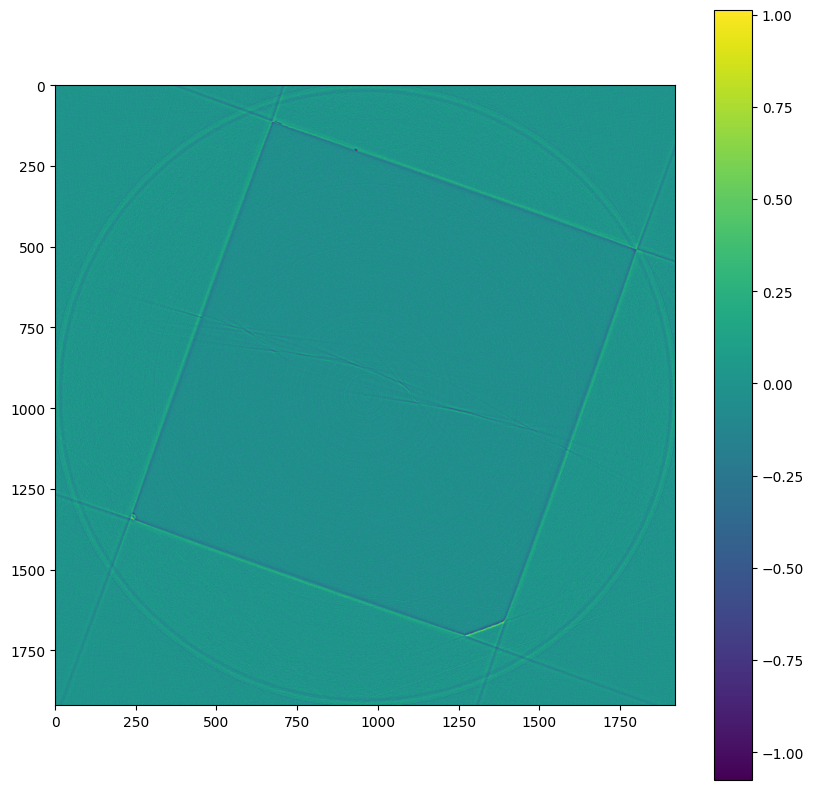

In [41]:
_ = nu.plot_recon(recon_original, 0)

In [ ]:
print(recon.shape)
print(type(recon))

In [ ]:
# Can be used to reset reconstruction
recon = copy.deepcopy(recon_original) 

In [ ]:
# Insert reconstruction pipeline here
recon[:] = sp.ndimage.gaussian_filter(recon, 0.5)

# binarize
voxel_values = vp.get_values_cyl_mask(recon[::2,::2,::2], 1.0)
rec_min_max = vp.modified_autocontrast(voxel_values, s=0.01)
thresh = np.float32(filters.threshold_otsu(voxel_values))    
recon[:] = (recon<thresh).astype(np.uint8)
#vp.cylindrical_mask(recon,0.7,1)

In [ ]:
im_layer = 0

w_ = nu.plot_recon_compare(recon_original, recon, im_layer)

In [ ]:
recon_labels, _ = sp.ndimage.label(recon, structure=np.ones((3,3,3), dtype=np.uint8))
voids_b = Voids().count_voids(recon_labels, pixel_ds, dust_thresh=1, pad_bb=2)    

In [ ]:
# Insert polygon pipeline here
#del projs, projs_original
#del recon, recon_original

In [ ]:
output_path = 'working_dir/pipeline_out/recon_faber.ply'


voids_b.export_void_mesh_mproc("sizes", edge_thresh=0).write_ply(
    os.path.join(output_path))